In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

RANDOM_STATE = 42


In [14]:
def build_preprocessor(df):
    num_cols = df.select_dtypes(include=np.number).columns.tolist()

    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ])

    return preprocessor


def evaluate_clustering(X, labels):
    return {
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels)
    }


In [15]:
DATASET_NAME = "01"  # поменяй на 02, 03

df = pd.read_csv(f"data/S07-hw-dataset-{DATASET_NAME}.csv")

display(df.head())
display(df.info())
display(df.describe())

sample_id = df["sample_id"]
X = df.drop(columns=["sample_id"])

preprocessor = build_preprocessor(X)
X_proc = preprocessor.fit_transform(X)


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


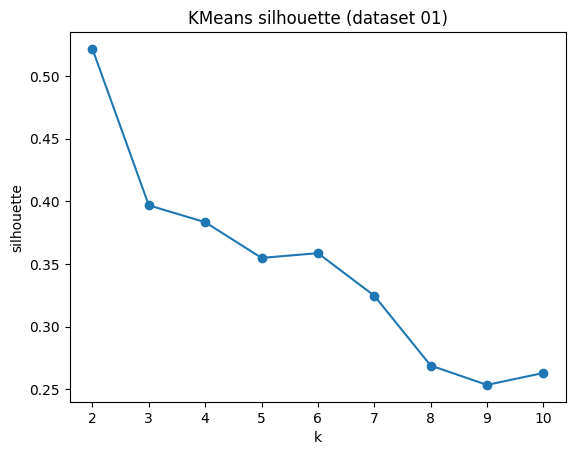

In [16]:
ks = range(2, 11)
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_proc)
    sil_scores.append(silhouette_score(X_proc, labels))

plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.title(f"KMeans silhouette (dataset {DATASET_NAME})")
plt.savefig(f"artifacts/figures/kmeans_sil_ds{DATASET_NAME}.png")
plt.show()

best_k = ks[np.argmax(sil_scores)]


In [17]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
agg_labels = agg.fit_predict(X_proc)


In [18]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
km_labels = kmeans.fit_predict(X_proc)

metrics_km = evaluate_clustering(X_proc, km_labels)
metrics_agg = evaluate_clustering(X_proc, agg_labels)

print("KMeans:", metrics_km)
print("Agglomerative:", metrics_agg)


KMeans: {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
Agglomerative: {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}


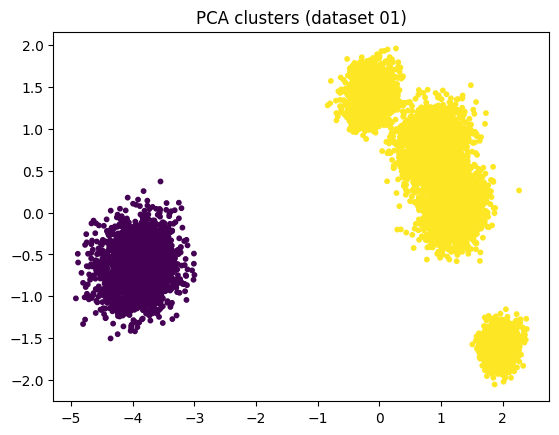

In [19]:
best_labels = km_labels  # можно заменить на agg_labels

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_proc)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, s=10)
plt.title(f"PCA clusters (dataset {DATASET_NAME})")
plt.savefig(f"artifacts/figures/pca_ds{DATASET_NAME}.png")
plt.show()


In [21]:
labels_df = pd.DataFrame({
    "sample_id": sample_id,
    "cluster_label": best_labels
})

labels_df.to_csv(
    f"artifacts/labels/labels_hw07_ds{DATASET_NAME}.csv",
    index=False
)


In [23]:
metrics_summary = {
    f"dataset_{DATASET_NAME}": {
        "kmeans": metrics_km,
        "agglomerative": metrics_agg,
        "best_k": best_k
    }
}

with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)


In [24]:
labels_list = []

for seed in range(5):
    km = KMeans(n_clusters=best_k, n_init=10, random_state=seed)
    labels_list.append(km.fit_predict(X_proc))

aris = []
for i in range(1, 5):
    aris.append(adjusted_rand_score(labels_list[0], labels_list[i]))

print("ARI:", aris, "mean:", np.mean(aris))


ARI: [1.0, 1.0, 1.0, 1.0] mean: 1.0


In [25]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

RANDOM_STATE = 42

os.makedirs("artifacts/figures", exist_ok=True)
os.makedirs("artifacts/labels", exist_ok=True)

def build_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    return ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols)
    ])

def eval_metrics(X_proc, labels):
    return {
        "silhouette": float(silhouette_score(X_proc, labels)),
        "davies_bouldin": float(davies_bouldin_score(X_proc, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X_proc, labels)),
    }

metrics_summary = {}
best_configs = {}

for ds in ["01", "02", "03"]:
    df = pd.read_csv(f"data/S07-hw-dataset-{ds}.csv")
    sample_id = df["sample_id"]
    X = df.drop(columns=["sample_id"])

    pre = build_preprocessor(X)
    X_proc = pre.fit_transform(X)

    # --- KMeans: подбор k ---
    ks = range(2, 11)
    sils = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
        labels = km.fit_predict(X_proc)
        sils.append(silhouette_score(X_proc, labels))

    best_k = int(list(ks)[int(np.argmax(sils))])

    plt.figure()
    plt.plot(list(ks), sils, marker="o")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.title(f"KMeans silhouette (dataset {ds})")
    plt.savefig(f"artifacts/figures/kmeans_sil_ds{ds}.png", dpi=160, bbox_inches="tight")
    plt.close()

    # --- Финальные модели ---
    km = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
    km_labels = km.fit_predict(X_proc)

    agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    agg_labels = agg.fit_predict(X_proc)

    m_km = eval_metrics(X_proc, km_labels)
    m_agg = eval_metrics(X_proc, agg_labels)

    # --- Выбор лучшего (простое правило: max silhouette) ---
    if m_km["silhouette"] >= m_agg["silhouette"]:
        best_name = "kmeans"
        best_labels = km_labels
        best_params = {"k": best_k, "random_state": RANDOM_STATE, "n_init": 10}
    else:
        best_name = "agglomerative"
        best_labels = agg_labels
        best_params = {"k": best_k, "linkage": "ward"}

    # --- PCA plot для лучшего ---
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_proc)

    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, s=10)
    plt.title(f"PCA clusters (dataset {ds}) | best={best_name}")
    plt.savefig(f"artifacts/figures/pca_ds{ds}.png", dpi=160, bbox_inches="tight")
    plt.close()

    # --- labels csv ---
    out = pd.DataFrame({"sample_id": sample_id, "cluster_label": best_labels})
    out.to_csv(f"artifacts/labels/labels_hw07_ds{ds}.csv", index=False)

    # --- summaries ---
    metrics_summary[f"dataset_{ds}"] = {
        "kmeans": m_km,
        "agglomerative": m_agg,
        "best_k": best_k
    }
    best_configs[f"dataset_{ds}"] = {
        "best_model": best_name,
        "criterion": "max silhouette",
        "params": best_params
    }

with open("artifacts/metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

with open("artifacts/best_configs.json", "w", encoding="utf-8") as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("DONE:",
      "labels =", len(os.listdir("artifacts/labels")),
      "figures =", len([x for x in os.listdir("artifacts/figures") if x.endswith('.png')]))


DONE: labels = 3 figures = 6
